In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import statsmodels.api as sm

# Load all datasets
file_deaths_population = "../data/processed/States_Deaths_Populations.csv"
file_poverty = "../data/processed/US_Poverty_Rate.csv"
file_income_per_capita = "../data/processed/Personal_Income_Per_Capita.csv"
file_health_care = "../data/processed/Personal_Health_Care_Per_Capita.csv"
file_median_income = "../data/processed/Median_Household_Income.csv"

# Read CSV files
df_deaths_population = pd.read_csv(file_deaths_population)
df_poverty = pd.read_csv(file_poverty)
df_income_per_capita = pd.read_csv(file_income_per_capita)
df_health_care = pd.read_csv(file_health_care)
df_median_income = pd.read_csv(file_median_income)

# Reshape "Income Per Capita" dataset to long format
df_income_per_capita_long = df_income_per_capita.melt(id_vars=["State"], var_name="Year", value_name="Income Per Capita")

# Convert "Year" to integer for consistency
df_income_per_capita_long["Year"] = df_income_per_capita_long["Year"].astype(int)

# Try merging all datasets
df_master = df_deaths_population.merge(df_poverty, on=["State", "Year"], how="left")
df_master = df_master.merge(df_income_per_capita_long, on=["State", "Year"], how="left")
df_master = df_master.merge(df_health_care, on=["State", "Year"], how="left")
df_master = df_master.merge(df_median_income, on=["State", "Year"], how="left")

# Recalculate Proportional Death Rate (deaths per 100,000 population)
df_master["Proportional Death Rate"] = (df_master["Deaths"] / df_master["Population"]) * 100000

print(df_master.head())

   Year       State  Deaths  Population  Age-adjusted Death Rate  \
0  1999     Alabama   35440     4430141                   1009.3   
1  1999      Alaska    2074      624779                    838.9   
2  1999     Arizona   31796     5023823                    818.4   
3  1999    Arkansas   22012     2651860                    975.3   
4  1999  California  186153    33499204                    802.3   

   Poverty Rate  Income Per Capita  Spending  Median Income  \
0          15.2              23296    3689.0        36251.0   
1           7.6              29941    4076.0        51396.0   
2          12.2              24866    3068.0        36995.0   
3          14.7              21842    3517.0        29682.0   
4          14.0              30529    3436.0        43629.0   

   Proportional Death Rate  
0               799.974538  
1               331.957380  
2               632.904463  
3               830.058902  
4               555.693801  


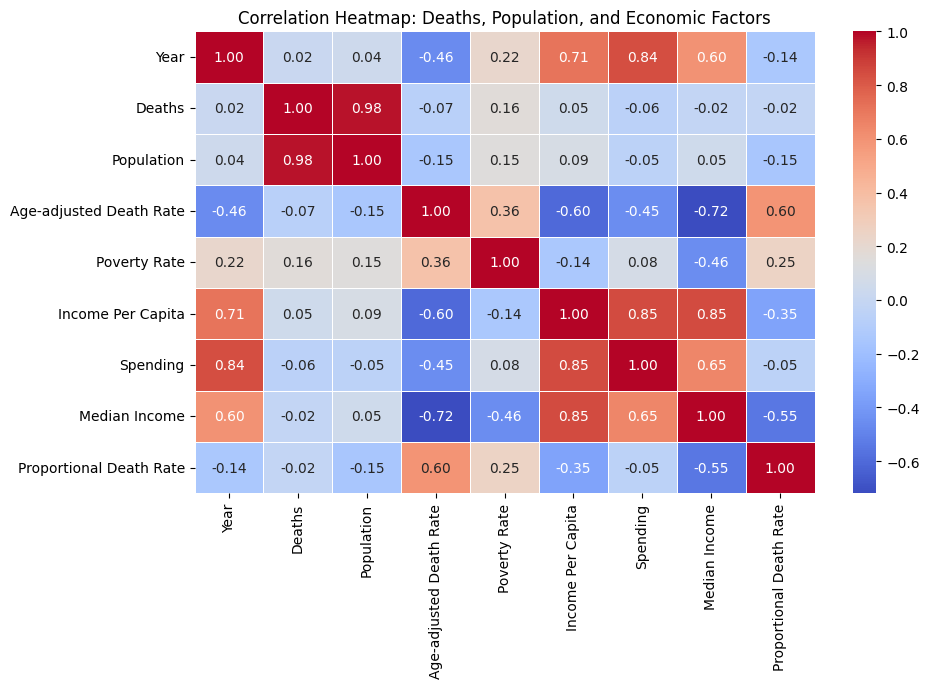

In [87]:
# Compute correlation matrix between deaths, population
numeric_df = df_master.select_dtypes(include=["number"])

# Compute correlation matrix for deaths, population, and economic factors
correlation_matrix = numeric_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Deaths, Population, and Economic Factors")
plt.show()

1. Deaths vs. Population → Strong positive correlation
This is expected because larger states have more total deaths.
2️. Proportional Death Rate vs. Population → Weak negative correlation
Suggests that larger states tend to have lower deaths per capita.
3️. Poverty Rate vs. Proportional Death Rate → Positive correlation
Higher poverty rates may be linked to higher death rates.
4️. Income Per Capita vs. Proportional Death Rate → Negative correlation
Suggests that wealthier states may have lower death rates.
5️. Healthcare Spending vs. Death Rates → Needs further investigation
The correlation may indicate whether higher spending actually reduces mortality.

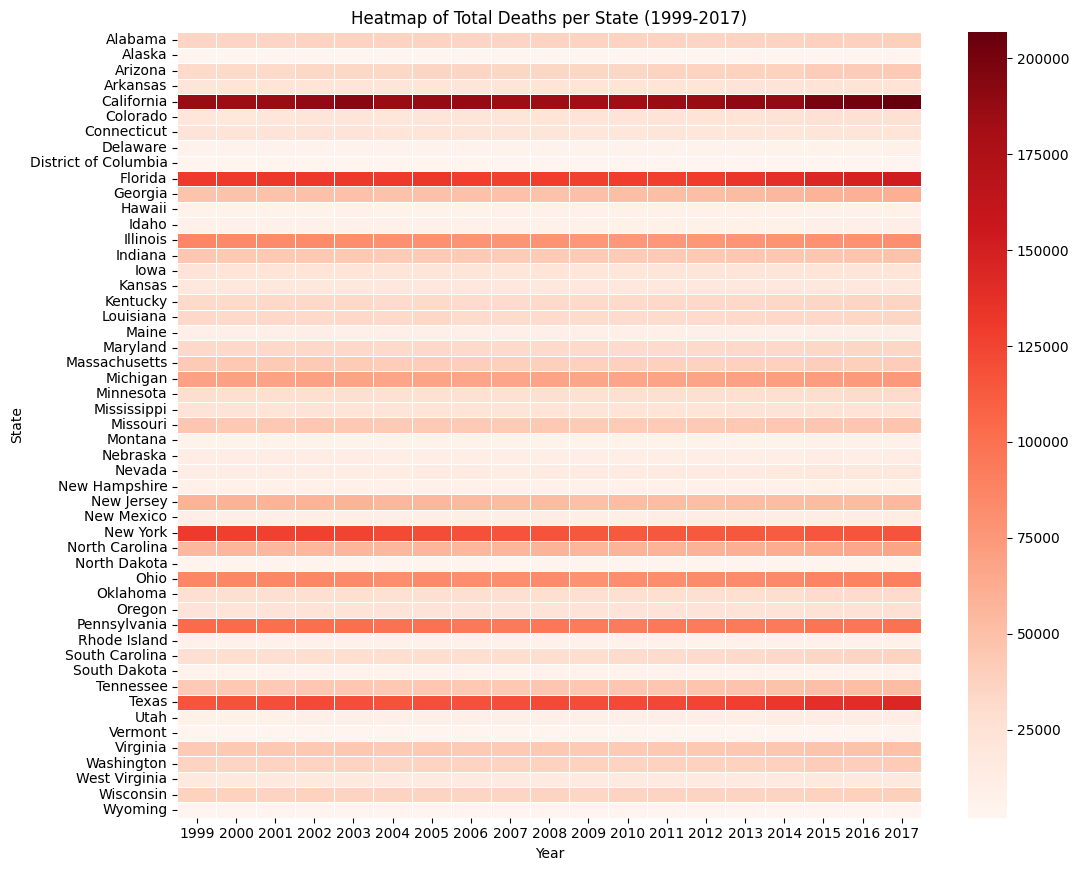

In [88]:
# Step 1: Create a heatmap for total deaths per state over time
heatmap_data_deaths = df_master.pivot(index="State", columns="Year", values="Deaths")

plt.figure(figsize=(12, len(heatmap_data_deaths) * 0.2))
sns.heatmap(heatmap_data_deaths, cmap="Reds", annot=False, linewidths=0.5)
plt.title("Heatmap of Total Deaths per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()


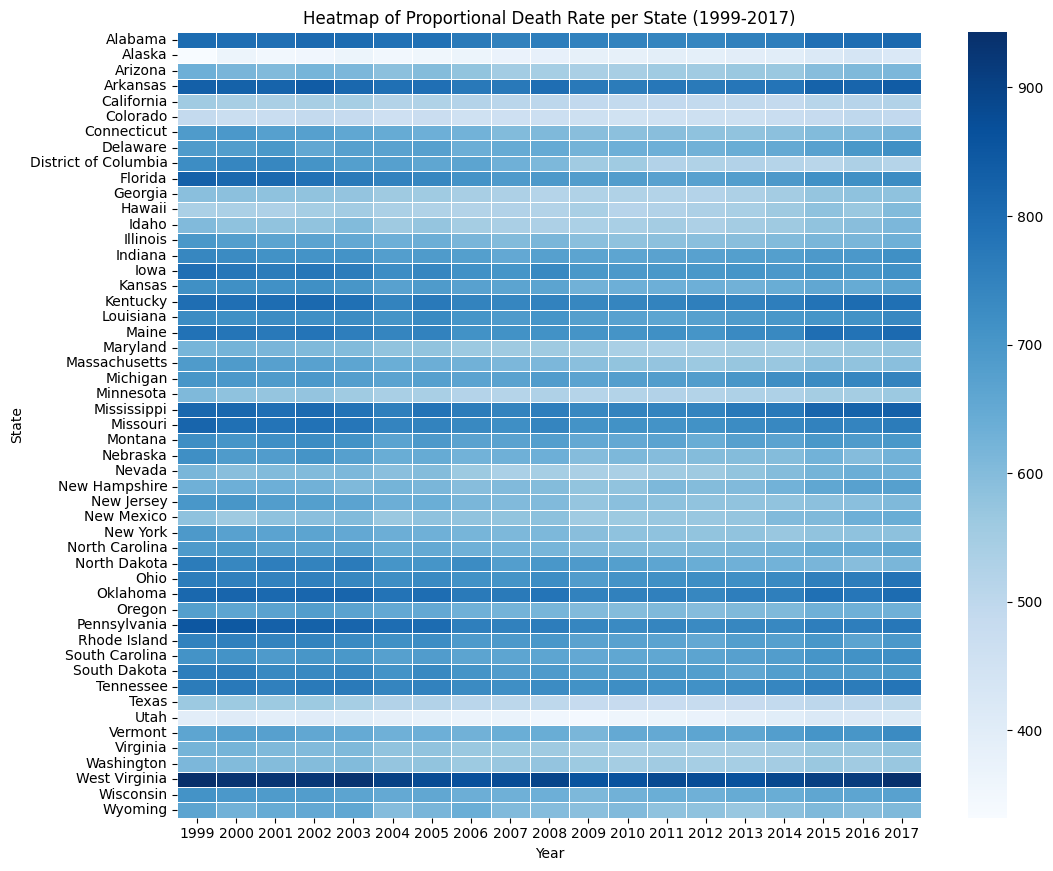

In [89]:
# Step 2: # Recalculate Proportional Death Rate (deaths per 100,000 population)
heatmap_data_proportional = df_master.pivot(index="State", columns="Year", values="Proportional Death Rate")

plt.figure(figsize=(12, len(heatmap_data_proportional) * 0.2))
sns.heatmap(heatmap_data_proportional, cmap="Blues", annot=False, linewidths=0.5)
plt.title("Heatmap of Proportional Death Rate per State (1999-2017)")
plt.xlabel("Year")
plt.ylabel("State")
plt.show()

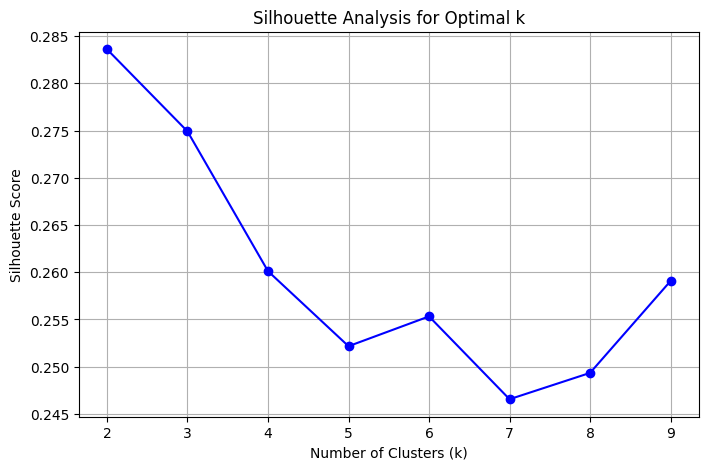

2


In [90]:
# Select relevant features for clustering
clustering_features = df_master[["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending"]]

# Handle missing values by filling with the mean
clustering_features = clustering_features.fillna(clustering_features.mean())

# Standardize the data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_features)

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)



         Proportional Death Rate  Poverty Rate  Income Per Capita     Spending
Cluster                                                                       
0                     574.746210     11.129730       54265.648649  9229.168919
1                     722.967954     11.847368       29243.110048  4779.258373
2                     679.554115     12.450467       42248.967290  7843.771028
3                     566.329986     16.547525       36107.089109  5978.742574
4                     767.971521     17.482500       34447.858333  6800.891667
5                     545.591119      9.490395       37058.858757  5390.988701


<Figure size 1200x600 with 0 Axes>

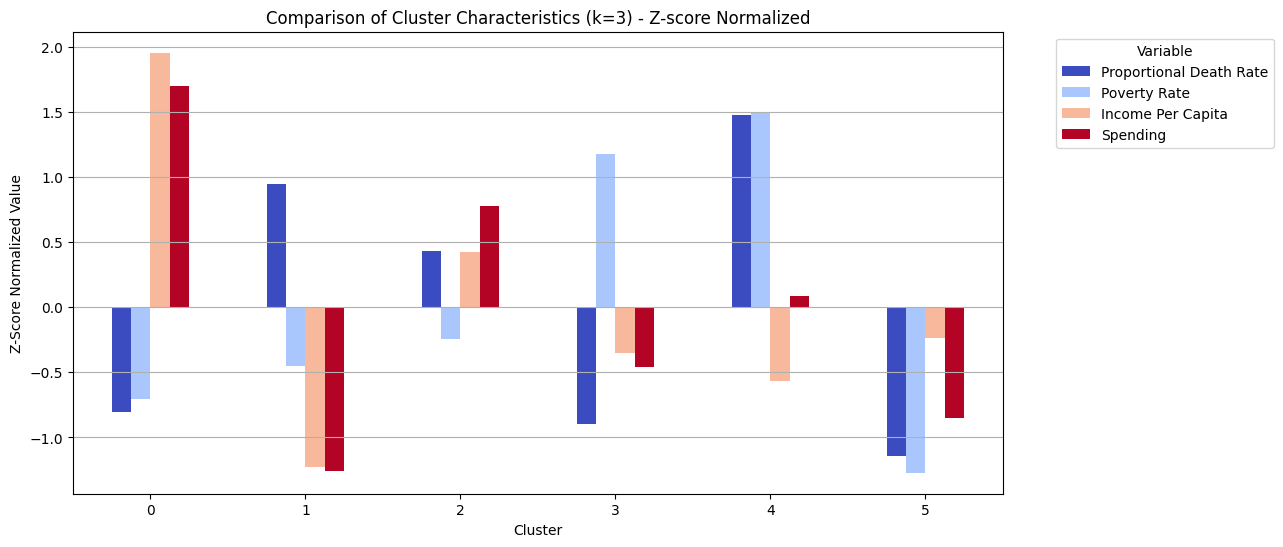

In [94]:

# Run K-Means Clustering with the optimal k = 3 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster (k=3) to interpret their meaning
cluster_characteristics_k3 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending"]
].mean()

print(cluster_characteristics_k3)

cluster_characteristics_zscore = pd.DataFrame(
    scaler.fit_transform(cluster_characteristics_k3),
    columns=cluster_characteristics_k3.columns,
    index=cluster_characteristics_k3.index
)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_zscore.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Z-score Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()


         Proportional Death Rate  Poverty Rate  Income Per Capita     Spending
Cluster                                                                       
0                     574.746210     11.129730       54265.648649  9229.168919
1                     722.967954     11.847368       29243.110048  4779.258373
2                     679.554115     12.450467       42248.967290  7843.771028
3                     566.329986     16.547525       36107.089109  5978.742574
4                     767.971521     17.482500       34447.858333  6800.891667
5                     545.591119      9.490395       37058.858757  5390.988701


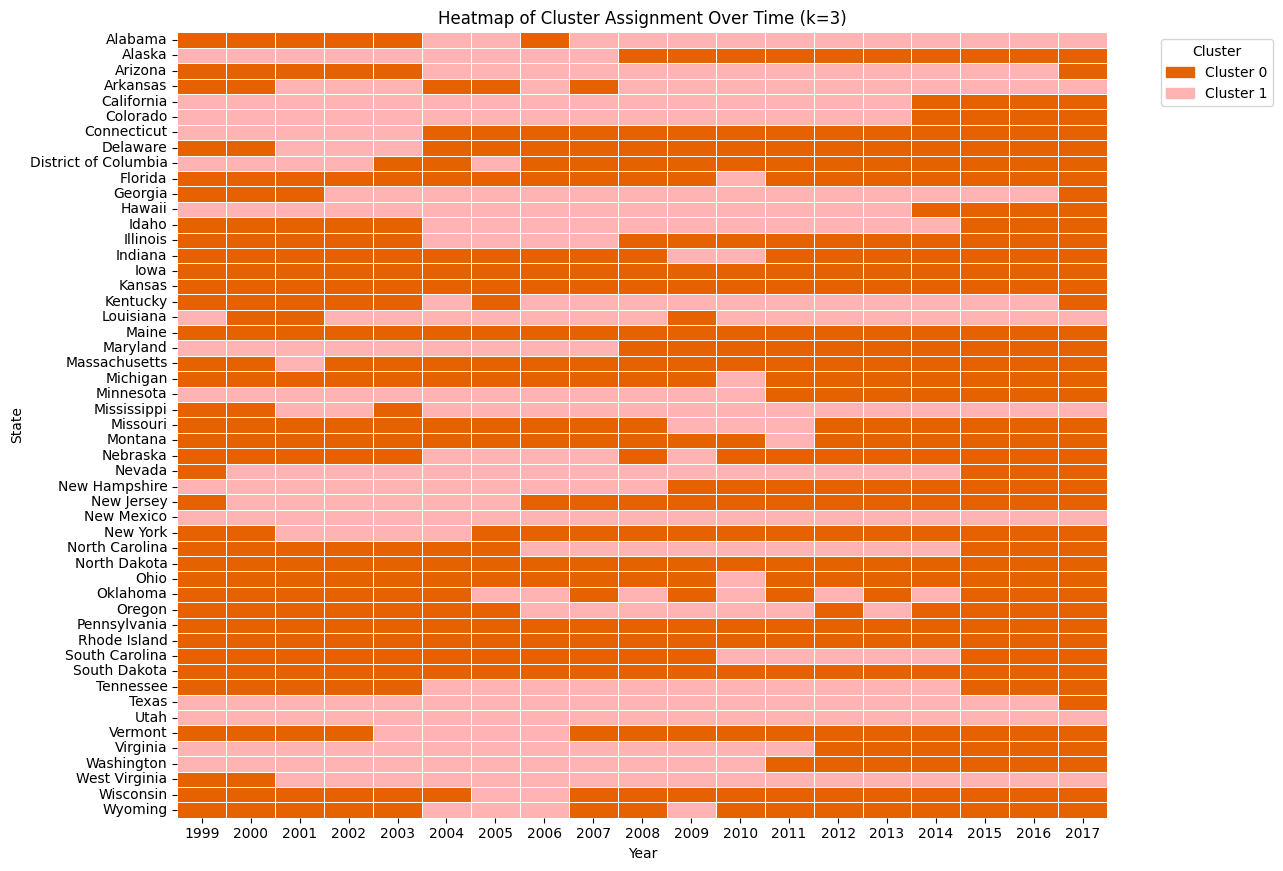

In [95]:
# Run K-Means Clustering with the optimal k = 2 (best separation)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["Cluster"] = kmeans.fit_predict(scaled_features)

# Compute the mean values of key variables for each cluster
cluster_characteristics_k3 = df_master.groupby("Cluster")[
    ["Proportional Death Rate", "Poverty Rate", "Income Per Capita", "Spending"]
].mean()

print(cluster_characteristics_k3)

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_data = df_master.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1
cluster_colors = ["#E66100", "#FFB3B3"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(2)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time (k=3)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()

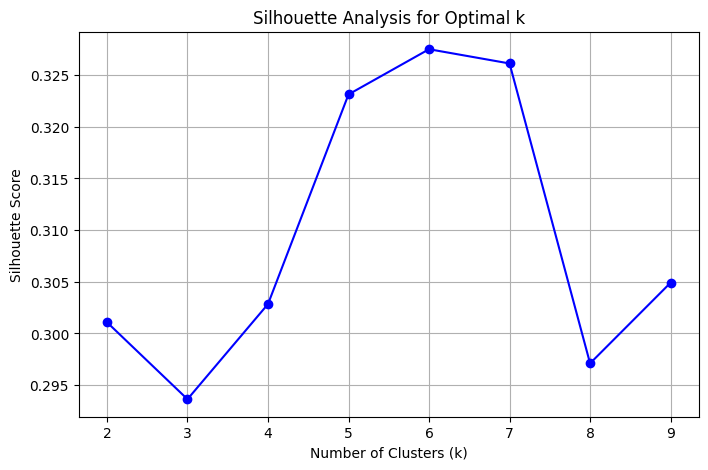

6
         Normalized Income Per Capita  Normalized Spending  \
Cluster                                                      
0                            1.257934             0.996441   
1                           -1.010446            -0.362332   
2                           -0.191061             0.203143   
3                           -0.664754            -1.055524   
4                            3.146335             3.400548   
5                            0.181943            -0.917771   

         Normalized Proportional Death Rate  Normalized Poverty Rate  
Cluster                                                               
0                                 -0.559182                -0.924379  
1                                  1.157709                 1.196238  
2                                  0.487024                -0.291898  
3                                 -0.666162                 0.920459  
4                                 -0.374112                 1.556728  
5   

<Figure size 1200x600 with 0 Axes>

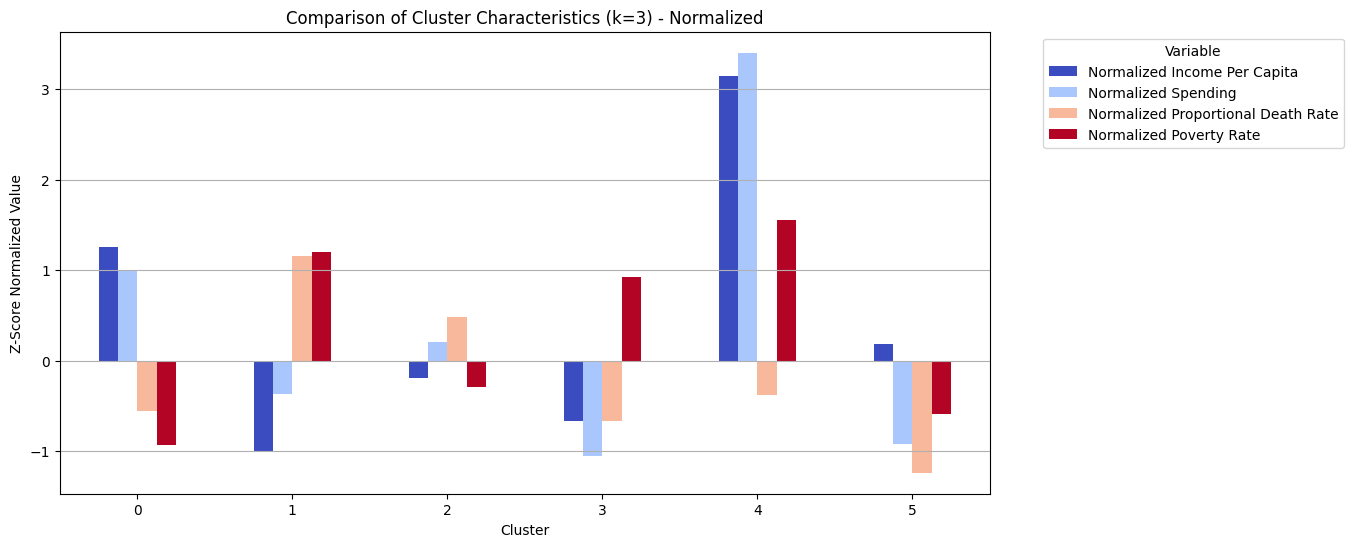

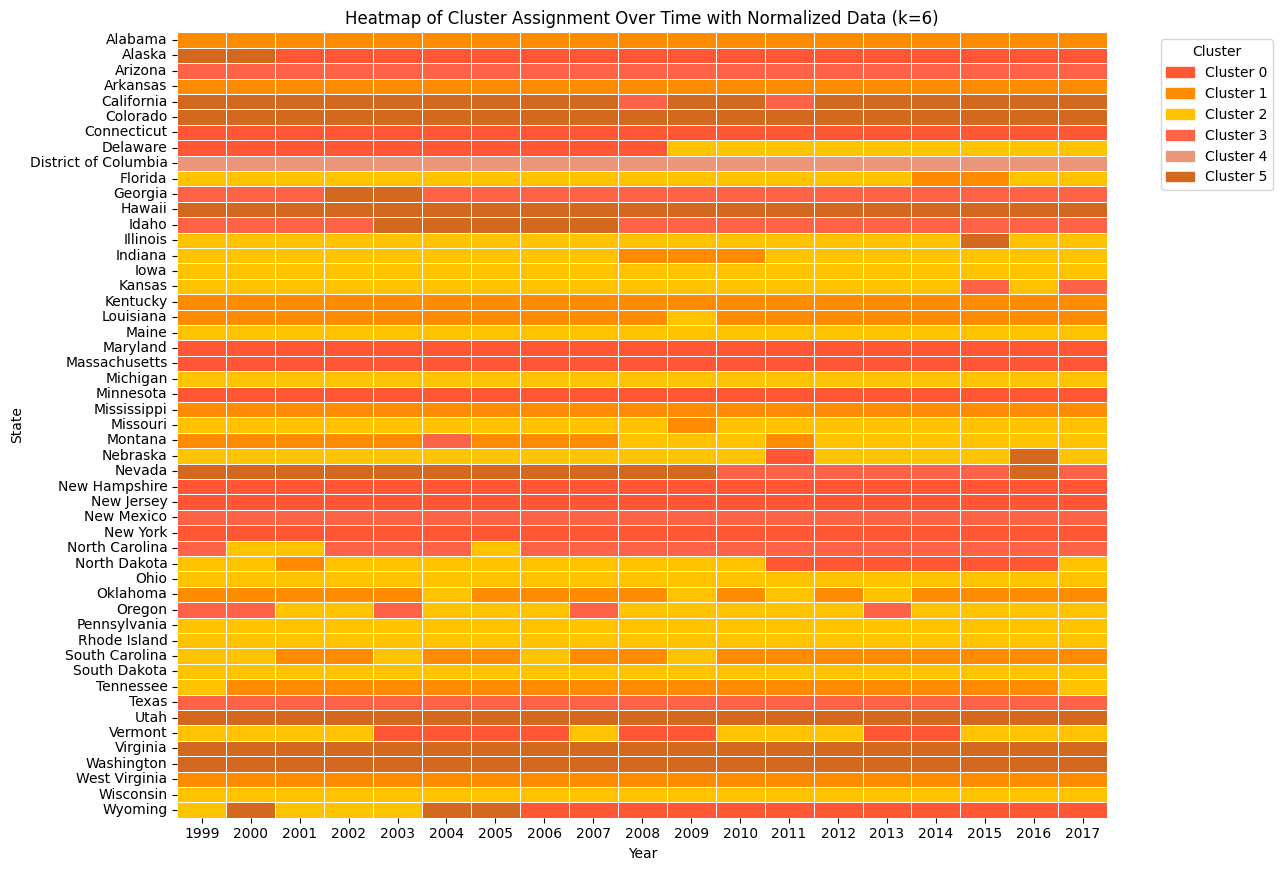

In [98]:
# Normalize selected columns by year
variables_to_normalize = ["Income Per Capita", "Spending", "Proportional Death Rate", "Poverty Rate"]
df_normalized = df_master.copy()

for var in variables_to_normalize:
    df_normalized[f"Normalized {var}"] = df_normalized.groupby("Year")[var].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    
# Select the normalized variables for clustering
normalized_features = [
    "Normalized Income Per Capita",
    "Normalized Spending",
    "Normalized Proportional Death Rate",
    "Normalized Poverty Rate",
]
    
scaler = StandardScaler()
scaled_normalized_features = scaler.fit_transform(df_normalized[normalized_features])

# Define the range of k values to test
k_values = range(2, 10)  # Testing cluster sizes from 2 to 9
silhouette_scores = []

# Iterate over different k values and compute the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_normalized_features)
    silhouette_avg = silhouette_score(scaled_normalized_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores to find the best k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker="o", linestyle="-", color="blue")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.grid(True)
plt.show()

# Find the optimal k with the highest silhouette score
optimal_k = k_values[np.argmax(silhouette_scores)]
print(optimal_k)

# Re-run K-Means clustering with k=3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_normalized["Cluster"] = kmeans.fit_predict(scaled_normalized_features)


# Display the new cluster characteristics
cluster_characteristics_normalized = df_normalized.groupby("Cluster")[
    normalized_features
].mean()

print(cluster_characteristics_normalized)

# Plot Z-score normalized data
plt.figure(figsize=(12, 6))
cluster_characteristics_normalized.plot(kind="bar", figsize=(12, 6), colormap="coolwarm")
plt.xlabel("Cluster")
plt.ylabel("Z-Score Normalized Value")
plt.title("Comparison of Cluster Characteristics (k=3) - Normalized")
plt.legend(title="Variable", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

# Create a heatmap to visualize the cluster distribution over time
cluster_heatmap_normalized_data = df_normalized.pivot_table(index="State", columns="Year", values="Cluster")

# Define a discrete colormap for clusters 0, 1, 2, 4, 5, 6
cluster_colors = ["#FF5733", "#FF8C00", "#FFC300", "#FF6347", "#E9967A", "#D2691E"]  # Assign colors to clusters
cmap = ListedColormap(cluster_colors)

# Create the heatmap
plt.figure(figsize=(12, len(cluster_heatmap_normalized_data) * 0.2))
ax = sns.heatmap(cluster_heatmap_normalized_data, cmap=cmap, annot=False, linewidths=0.5, cbar=False)

# Create a custom legend
legend_patches = [Patch(color=cluster_colors[i], label=f"Cluster {i}") for i in range(6)]
plt.legend(handles=legend_patches, title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Titles and labels
plt.title("Heatmap of Cluster Assignment Over Time with Normalized Data (k=6)")
plt.xlabel("Year")
plt.ylabel("State")

# Show plot
plt.show()